In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits

Write the FITS list files for each subdirectory (bias, flat, science) of the group10_WASP-135_20190803 folder. The goal is to creat a list containing all the files names so that we can access them easily.

In [3]:
bias_list = np.genfromtxt('./group10_WASP-135_20190803/bias/bias.list', dtype=str)
print(bias_list)

['AF560570.fits' 'AF560571.fits' 'AF560572.fits' 'AF560573.fits'
 'AF560574.fits' 'AF560575.fits' 'AF560576.fits' 'AF560577.fits'
 'AF560578.fits' 'AF560579.fits' 'AF560580.fits' 'AF560581.fits'
 'AF560582.fits' 'AF560583.fits' 'AF560584.fits' 'AF560585.fits'
 'AF560586.fits' 'AF560587.fits' 'AF560588.fits' 'AF560589.fits'
 'AF560590.fits' 'AF560591.fits' 'AF560592.fits' 'AF560593.fits'
 'AF560594.fits' 'AF560595.fits' 'AF560596.fits' 'AF560597.fits'
 'AF560598.fits' 'AF560599.fits']


### Extract information from a FITS file
We now open a single FITS file ($\texttt{bias\_list[0]}$, so the first bias file), we store its primary HDU into a variable and we print the header with. All of this is accomplished through $\texttt{astropy.io.fits}$ methods.

In [4]:
# With this command we are opening the file corresponding to the path up to /bias/ + its name.
bias00_fits = fits.open('./group10_WASP-135_20190803/bias/' + bias_list[0])
# The primary HDU is stored into the first place in the fits file.
bias00_hdu = bias00_fits[0]
#print(bias00_hdu)
#The header contains a lot of information regarding the fits file.
bias00_hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  521 / length of data axis 1                          
NAXIS2  =                  119 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2019-08-03T23:24:16' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'AF560570.fits'      / Original file name                             
TIMESYS = 'UTC     '        

From the header we can retrieve some useful data about the fits file. We will import $\textit{time}$, $\textit{airmass}$, $\textit{gain}$ and $\textit{readout noise}$. In order to retrieve their units we use the $\texttt{comments}$ attribute of the header.

In [5]:
bias00_time = bias00_hdu.header['JD'] #Contains the Julian Date
bias00_airmass = bias00_hdu.header['AIRMASS'] #Contains the airmass
bias00_gain = bias00_hdu.header['GAIN'] #Contains the gain
bias00_readout_noise = bias00_hdu.header['RDNOISE'] #Contains the readout noise

bias00_gain_comment = bias00_hdu.header.comments['GAIN']
bias00_ron_comment = bias00_hdu.header.comments['RDNOISE']

print('Julian date       : {0:12.6f} JD'.format(bias00_time))
print('CCD Gain          : {0:4.2f} {1:.8s}'.format(bias00_gain, bias00_gain_comment))
print('CCD Readout noise : {0:4.2f} {1:.3s}'.format(bias00_readout_noise, bias00_ron_comment))

Julian date       : 2458699.475185 JD
CCD Gain          : 1.91 [e/ADU] 
CCD Readout noise : 7.10 [e]


### Shape of an image in Python

Since we have many frames, we will take their median. In order to compute it, we need to open and save all the frames somewhere. We have to create a $\texttt{stack}$ with enough space to keep all the images. We can know the shape of the picture by looking at the header of the .fits file, in particular at NAXIS1 and NAXIS2.

$\textbf{N.B.}$:
For CCD images, the first index indicates the x coordinate (i.e., the column) and the second indicates the y position (i.e., the row). In mathematical matrix notation, the first index indicates the row, and the second indicates the column.

In [10]:
bias00_naxis1 = bias00_hdu.header['NAXIS1']
bias00_naxis2 = bias00_hdu.header['NAXIS2']
print('Shape of the FITS image from the header: {0:4d} x {1:4d}'.format(bias00_naxis1, bias00_naxis2))


Shape of the FITS image from the header:  521 x  119


The only way to do things correctly is to check the size of our array using the numpy.shape function. In order to do so, we need to extract the data from the fits file:

bias00_hdu.data contains the raw data of the FITS image as a NumPy array. Each value represents the intensity level measured by a pixel on the CCD, expressed in ADU (Analog-to-Digital Units). The GAIN, specified in the FITS header, is a parameter that converts ADU values into electrons ([e⁻/ADU]), providing a physically meaningful measure of the acquired signal. The multiplication by the GAIN (bias00_data = bias00_hdu.data * bias00_gain) transforms the data from arbitrary digital units (ADU) into actual electron counts per pixel. This step is crucial to ensure a physically meaningful analysis of the acquired data.

In [12]:
bias00_data = bias00_hdu.data * bias00_gain
#Assign the dimension to two variables
bias00_nparray_dim00, bias00_nparray_dim01 = np.shape(bias00_data)

print('Shape of the NumPy array extracted by astropy: {0:4d} x {1:4d}'.format(bias00_nparray_dim00, bias00_nparray_dim01))
print('Our image is saved as a ', type(bias00_data))

#Our image is a numpy matrix

Shape of the NumPy array extracted by astropy:  119 x  521
Our image is saved as a  <class 'numpy.ndarray'>


We got the opposite result with respect to the NAXIS method. This means the in the bias00_data[i,j] array, i is the indes of the row and j is the index of the coulmn and it is inverted with respect to the coordinate systems defined in the FITS file. We need to be self-consistent with this notation.

#### Save the frames into a 3D array

First we check how many images we have, then we create the stack of the right dimension.

Once we have built the stack we need to populate it with all the frames and compute the median along the first axis of the 3D matrix.

In [19]:
n_images = len(bias_list)

#We create a 3D object (N matrices of dimension 00 x 01)
stack = np.empty([n_images, bias00_nparray_dim00, bias00_nparray_dim01])

for i, bias_name in enumerate(bias_list):
    bias_temp = fits.open('./group10_WASP-135_20190803/bias/' + bias_name) #We open the i-th file
    stack[i, :, :] = bias_temp[0].data * bias_temp[0].header['GAIN'] #We multiply its data by the gain and store it in the i-th matrix of the stack
    bias_temp.close() #We close the fits file to free the RAM

median_bias = np.median(stack, axis=0) #Means we take the median of the N matrices.
np.shape(median_bias) #We find a matrix of the same dimension as the single frames.

(119, 521)

### Plotting a single bias and a median bias

We need to change the origin of the plot by specifying origin='lower' to match the reference frame of the FITS standard.

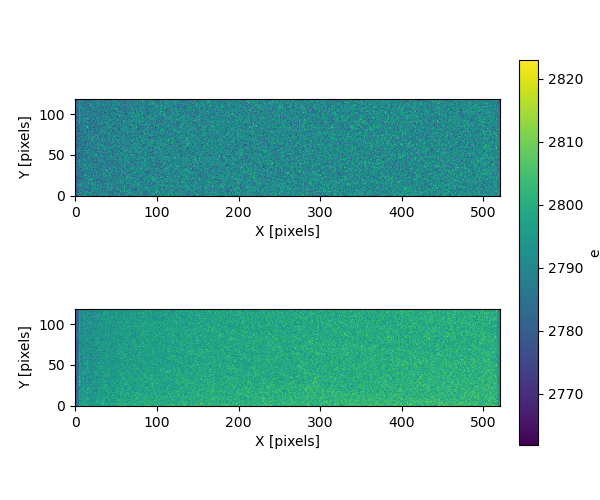

In [24]:
fig, ax = plt.subplots(2,1, figsize=(6,5))

im1 = ax[0].imshow(bias00_data, origin='lower')
im2 = ax[1].imshow(median_bias, origin='lower')

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')
ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Y [pixels]')
plt.show()